<a href="https://colab.research.google.com/github/dilaishma/Ch.1_Foundation_for_AI/blob/main/Glaura_DenseNet169.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import torchvision
import os
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import torch
import random
import torch.nn as nn
import torch.optim as optim

In [ ]:
!kaggle datasets download -d deathtrooper/glaucoma-dataset-eyepacs-airogs-light-v2 -p /content/sample_data

Dataset URL: https://www.kaggle.com/datasets/deathtrooper/glaucoma-dataset-eyepacs-airogs-light-v2
License(s): other
 95% 500M/524M [00:04<00:00, 165MB/s]
100% 524M/524M [00:04<00:00, 129MB/s]


In [ ]:
with zipfile.ZipFile("/content/sample_data/glaucoma-dataset-eyepacs-airogs-light-v2.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [ ]:
dataset_path = '/content/eyepac-light-v2-512-jpg'

for main_folder in ['train', 'test', 'validation']:
    print(main_folder.upper())
    for sub_folder in ['RG', 'NRG']:
        folder_path = os.path.join(dataset_path, main_folder, sub_folder)
        num_files = len(os.listdir(folder_path))
        print(f"{sub_folder}: {num_files}")
    print("=================================")


TRAIN
RG: 4000
NRG: 4000
TEST
RG: 385
NRG: 385
VALIDATION
RG: 385
NRG: 385


In [ ]:
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True

# **DATA PREPROCESSING**

In [ ]:
stats = ((0.3569, 0.2273, 0.1467), (0.2023, 0.1994, 0.210))
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(20), # rotasi random antara -20 sampai 20 derajat
    torchvision.transforms.RandomHorizontalFlip(), # flip secara horizontal
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(*stats, inplace=True)
    ])

In [ ]:
EPOCH = 10
BATCH_SIZE = 15
LR = 0.001

In [ ]:
train_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'train'), transform=data_transform)
test_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'test'), transform=data_transform)
validation_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'validation'), transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def fit(
    model : torchvision.models,
    epoch : int,
    train_loader : torch.utils.data.DataLoader,
    val_loader : torch.utils.data.DataLoader,
    *args, **kwargs
) -> dict:

    TRAIN_LOSS, TRAIN_ACC = [], []
    train_batches = len(train_loader)

    VAL_LOSS, VAL_ACC = [], []
    val_batches = len(val_loader)

    # loop for every epoch (training + evaluation)
    start_ts = time.time()
    for e in range(epoch):
        train_losses = 0
        train_accuracies = 0

        # progress bar
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=train_batches)

        # ----------------- TRAINING  --------------------
        # set model to training
        model.train()

        for i, data in progress:
            X, y = data[0].to(device), data[1].to(device)

            # training step for single batch
            model.zero_grad()

            # forward pass
            outputs = model(X)
            loss = loss_function(outputs, y)

            # backward pass
            loss.backward()
            optimizer.step()

            train_losses += loss.item()

            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y.view(*top_class.shape)
            train_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

            # updating progress bar
            progress.set_description("Loss: {:.4f}".format(train_losses/(i+1)))

        TRAIN_ACC.append(train_accuracies/train_batches)
        TRAIN_LOSS.append(train_losses/train_batches)

        # releasing unceseccary memory in GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ----------------- VALIDATION  -----------------
        val_losses = 0
        val_accuracies = 0

        # set model to evaluating (testing)
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                X, y = data[0].to(device), data[1].to(device)
                outputs = model(X) # this gives the prediction from the network
                val_losses += loss_function(outputs, y).item()

                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == y.view(*top_class.shape)
                val_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

        print("Epoch {}/{} >> Training loss: {:.3f}, Validation loss: {:.3f}, Validation accuracy: {:.3f}".format(
            e+1, epoch, train_losses/train_batches, val_losses/val_batches, val_accuracies/val_batches*100)
        )

        VAL_ACC.append(val_accuracies/val_batches)
        VAL_LOSS.append(val_losses/val_batches)

    tr_time = time.time()-start_ts
    print("Training time: {:.3f}s".format(tr_time))

    return {
        "model" : model.name,
        "train_acc" : TRAIN_ACC,
        "train_loss" : TRAIN_LOSS,
        "val_acc" : VAL_ACC,
        "val_loss" : VAL_LOSS,
        "exc_time" : tr_time
    }

In [ ]:
def plot_performance(dict_ : dict, *args, **kwargs) -> None:
    my_figure = plt.figure(figsize=(12, 4))
    # NOTE: figsize=(width/horizontally, height/vertically)

    m = my_figure.add_subplot(121)
    plt.plot(dict_["train_loss"], label="Train Loss")
    plt.plot(dict_["val_loss"], label="Valid. Loss")
    plt.title("LOSS")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    n = my_figure.add_subplot(122)
    plt.plot(dict_["train_acc"], label="Train Accuracy")
    plt.plot(dict_["val_acc"], label="Valid. Accuracy")
    plt.title("ACCURACY")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
EPOCH = 10
BATCH_SIZE = 10
LEARNING_RATE = 0.0001

In [ ]:
model = models.densenet169(pretrained=True)
model.name = "densenet169"
model.classifier = nn.Linear(model.classifier.in_features, 2)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 78.2MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
import time
from tqdm import tqdm
result = fit(model, EPOCH, train_loader, valid_loader, loss_function, optimizer)

Loss: 0.3881: 100%|██████████| 534/534 [09:23<00:00,  1.06s/it]


Epoch 1/10 >> Training loss: 0.388, Validation loss: 0.271, Validation accuracy: 88.846


Loss: 0.2399: 100%|██████████| 534/534 [09:14<00:00,  1.04s/it]


Epoch 2/10 >> Training loss: 0.240, Validation loss: 0.170, Validation accuracy: 93.333


Loss: 0.2040: 100%|██████████| 534/534 [09:12<00:00,  1.04s/it]


Epoch 3/10 >> Training loss: 0.204, Validation loss: 0.176, Validation accuracy: 93.462


Loss: 0.1871: 100%|██████████| 534/534 [09:12<00:00,  1.04s/it]


Epoch 4/10 >> Training loss: 0.187, Validation loss: 0.194, Validation accuracy: 91.667


Loss: 0.1623: 100%|██████████| 534/534 [09:14<00:00,  1.04s/it]


Epoch 5/10 >> Training loss: 0.162, Validation loss: 0.149, Validation accuracy: 94.615


Loss: 0.1495: 100%|██████████| 534/534 [09:12<00:00,  1.03s/it]


Epoch 6/10 >> Training loss: 0.150, Validation loss: 0.180, Validation accuracy: 93.077


Loss: 0.1455: 100%|██████████| 534/534 [09:27<00:00,  1.06s/it]


Epoch 7/10 >> Training loss: 0.146, Validation loss: 0.158, Validation accuracy: 93.718


Loss: 0.1265: 100%|██████████| 534/534 [09:13<00:00,  1.04s/it]


Epoch 8/10 >> Training loss: 0.127, Validation loss: 0.163, Validation accuracy: 93.590


Loss: 0.1161: 100%|██████████| 534/534 [09:15<00:00,  1.04s/it]


Epoch 9/10 >> Training loss: 0.116, Validation loss: 0.157, Validation accuracy: 93.333


Loss: 0.1128: 100%|██████████| 534/534 [09:14<00:00,  1.04s/it]


Epoch 10/10 >> Training loss: 0.113, Validation loss: 0.176, Validation accuracy: 93.077
Training time: 5761.296s


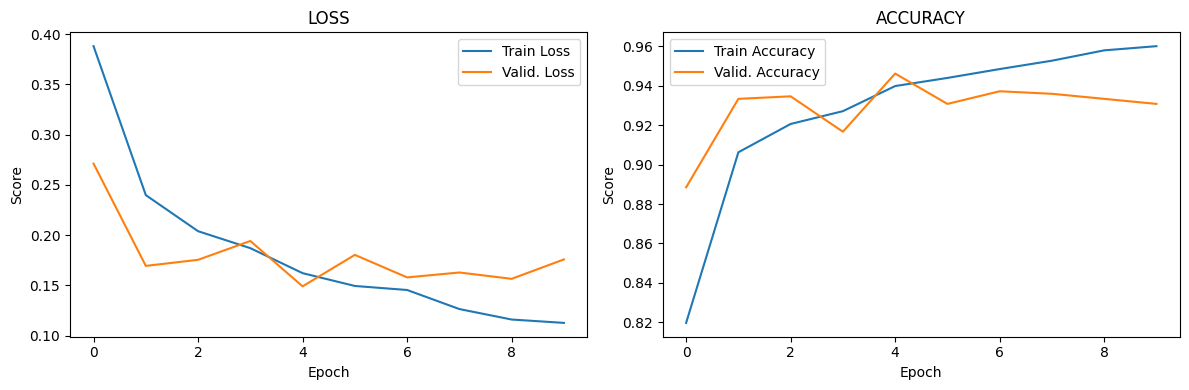

In [ ]:
plot_performance(result)

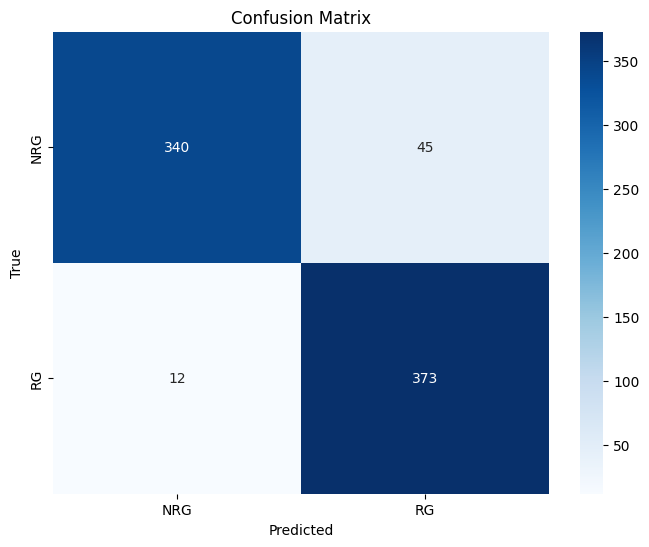

Accuracy: 0.925974025974026
Precision: 0.8923444976076556
Recall: 0.9688311688311688
F1 Score: 0.9290161892901619


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np


y_pred = []
y_true = []


model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(y_true, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:

torch.save(model.state_dict(), 'Glaura-DenseNet169.pth')

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import os
import torchvision.models as models
import torch.nn as nn


def load_model(model_path):
    model = models.densenet169(pretrained=False)
    model.classifier = nn.Linear(model.classifier.in_features, 2)

    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.eval()
    return model

def preprocess_image(image_path):
  stats = ((0.3569, 0.2273, 0.1467), (0.2023, 0.1994, 0.210))
  transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])
  image = Image.open(image_path).convert('RGB')
  return transform(image).unsqueeze(0)


def classify_images(folder_path, model, class_names):
    results = {}
    for file_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, file_name)
        if os.path.isfile(image_path) and file_name.lower().endswith(('png', 'jpg', 'jpeg')):
            image_tensor = preprocess_image(image_path)
            with torch.no_grad():
                outputs = model(image_tensor)
                _, predicted = torch.max(outputs, 1)
                results[file_name] = class_names[predicted.item()]
    return results


model_path = "/content/Glaura-DenseNet169.pth"
image_folder = "/content/Uji Coba"
class_names = ["NRG", "RG"]

model = load_model(model_path)

classification_results = classify_images(image_folder, model, class_names)

for file_name, class_name in classification_results.items():
    print(f"{file_name}: {class_name}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-10-6449bcef75ce>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

EyePACS-NRG-2774.jpg: NRG
EyePACS-NRG-2815.jpg: NRG
EyePACS-Glaucoma-2808.jpg: RG
EyePACS-NRG-2792.jpg: NRG
EyePACS-NRG-2813.jpg: NRG
EyePACS-NRG-2788.jpg: NRG
EyePACS-NRG-2781.jpg: NRG
EyePACS-Glaucoma-2789.jpg: RG
EyePACS-Glaucoma-2814.jpg: RG
EyePACS-Glaucoma-2809.jpg: RG
EyePACS-Glaucoma-2771.jpg: RG
EyePACS-NRG-2806.jpg: NRG
EyePACS-NRG-2772.jpg: RG
EyePACS-NRG-2793.jpg: NRG
EyePACS-Glaucoma-2798.jpg: RG
EyePACS-Glaucoma-2805.jpg: RG
EyePACS-Glaucoma-2782.jpg: RG
EyePACS-Glaucoma-2779.jpg: RG
EyePACS-Glaucoma-2786.jpg: RG
EyePACS-NRG-2805.jpg: NRG
